In [1]:
import numpy as np
from sklearn.model_selection import KFold
import scipy.io as sio
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
crossvalidation = False
data_path 	= './dataset/'
NO_splits = 5 # number of folds in cross validation
NO_channels = 22 # number of EEG channels
NO_subjects = 9
Window_Length = 7*250
NO_tests = 6*48

In [3]:
def get_data(subject,training,PATH):
	class_return = np.zeros(NO_tests)
	data_return = np.zeros((NO_tests,NO_channels,Window_Length))

	NO_valid_trial = 0
	if training:
		a = sio.loadmat(PATH+'A0'+str(subject)+'T.mat')
	else:
		a = sio.loadmat(PATH+'A0'+str(subject)+'E.mat')
	a_data = a['data']
	for ii in range(0,a_data.size):
		a_data1 = a_data[0,ii]
		a_data2=[a_data1[0,0]]
		a_data3=a_data2[0]
		a_X 		= a_data3[0]
		a_trial 	= a_data3[1]
		a_y 		= a_data3[2]
		a_fs 		= a_data3[3]
		a_classes 	= a_data3[4]
		a_artifacts = a_data3[5]
		a_gender 	= a_data3[6]
		a_age 		= a_data3[7]
		for trial in range(0,a_trial.size):
			if(a_artifacts[trial]==0):
				data_return[NO_valid_trial,:,:] = np.transpose(a_X[int(a_trial[trial]):(int(a_trial[trial])+Window_Length),:22])
				class_return[NO_valid_trial] = int(a_y[trial])
				NO_valid_trial +=1


	return data_return[0:NO_valid_trial,:,:], class_return[0:NO_valid_trial]

In [4]:
def load_data(subject):
        if crossvalidation:
            data,label = get_data(subject ,True, data_path)
            kf = KFold(n_splits=NO_splits)
            split = 0
            for train_index, test_index in kf.split(data):
                if split == split:
                    train_data = data[train_index]
                    train_label = label[train_index]
                    eval_data = data[test_index]
                    eval_label = label[test_index]
                split += 1
        else:
            train_data, train_label = get_data(subject, True, data_path)
            eval_data, eval_label = get_data(subject, False, data_path)

        return train_data, train_label, eval_data, eval_label

In [5]:
y_train = []
y_eval = []
X_train_mean = []
X_eval_mean = []


for subject in range(1,NO_subjects+1):
    train_data, train_label, eval_data, eval_label = load_data(subject)
    y_train.append(train_label)
    y_eval.append(eval_label)
    X_train_mean.append(np.mean(train_data, axis=1))
    X_eval_mean.append(np.mean(eval_data, axis=1))

In [6]:
print(len(X_train_mean))
print(len(y_train))
print(len(X_eval_mean))
print(len(y_eval))

9
9
9
9


Only for subject 1

In [7]:
subject = 1

In [8]:
print(X_train_mean[subject-1].shape)
print(y_train[subject-1].shape)
print(X_eval_mean[subject-1].shape)
print(y_eval[subject-1].shape)

(273, 1750)
(273,)
(281, 1750)
(281,)


In [12]:
# Concatenate X_train_mean and X_eval_mean along the first axis
X = np.concatenate((X_train_mean[subject-1], X_eval_mean[subject-1]), axis=0)

# Concatenate y_train and y_eval
y = np.concatenate((y_train[subject-1], y_eval[subject-1]), axis=0)

print("X shape:", X.shape)
print("Y shape:", y.shape)

X shape: (554, 1750)
Y shape: (554,)


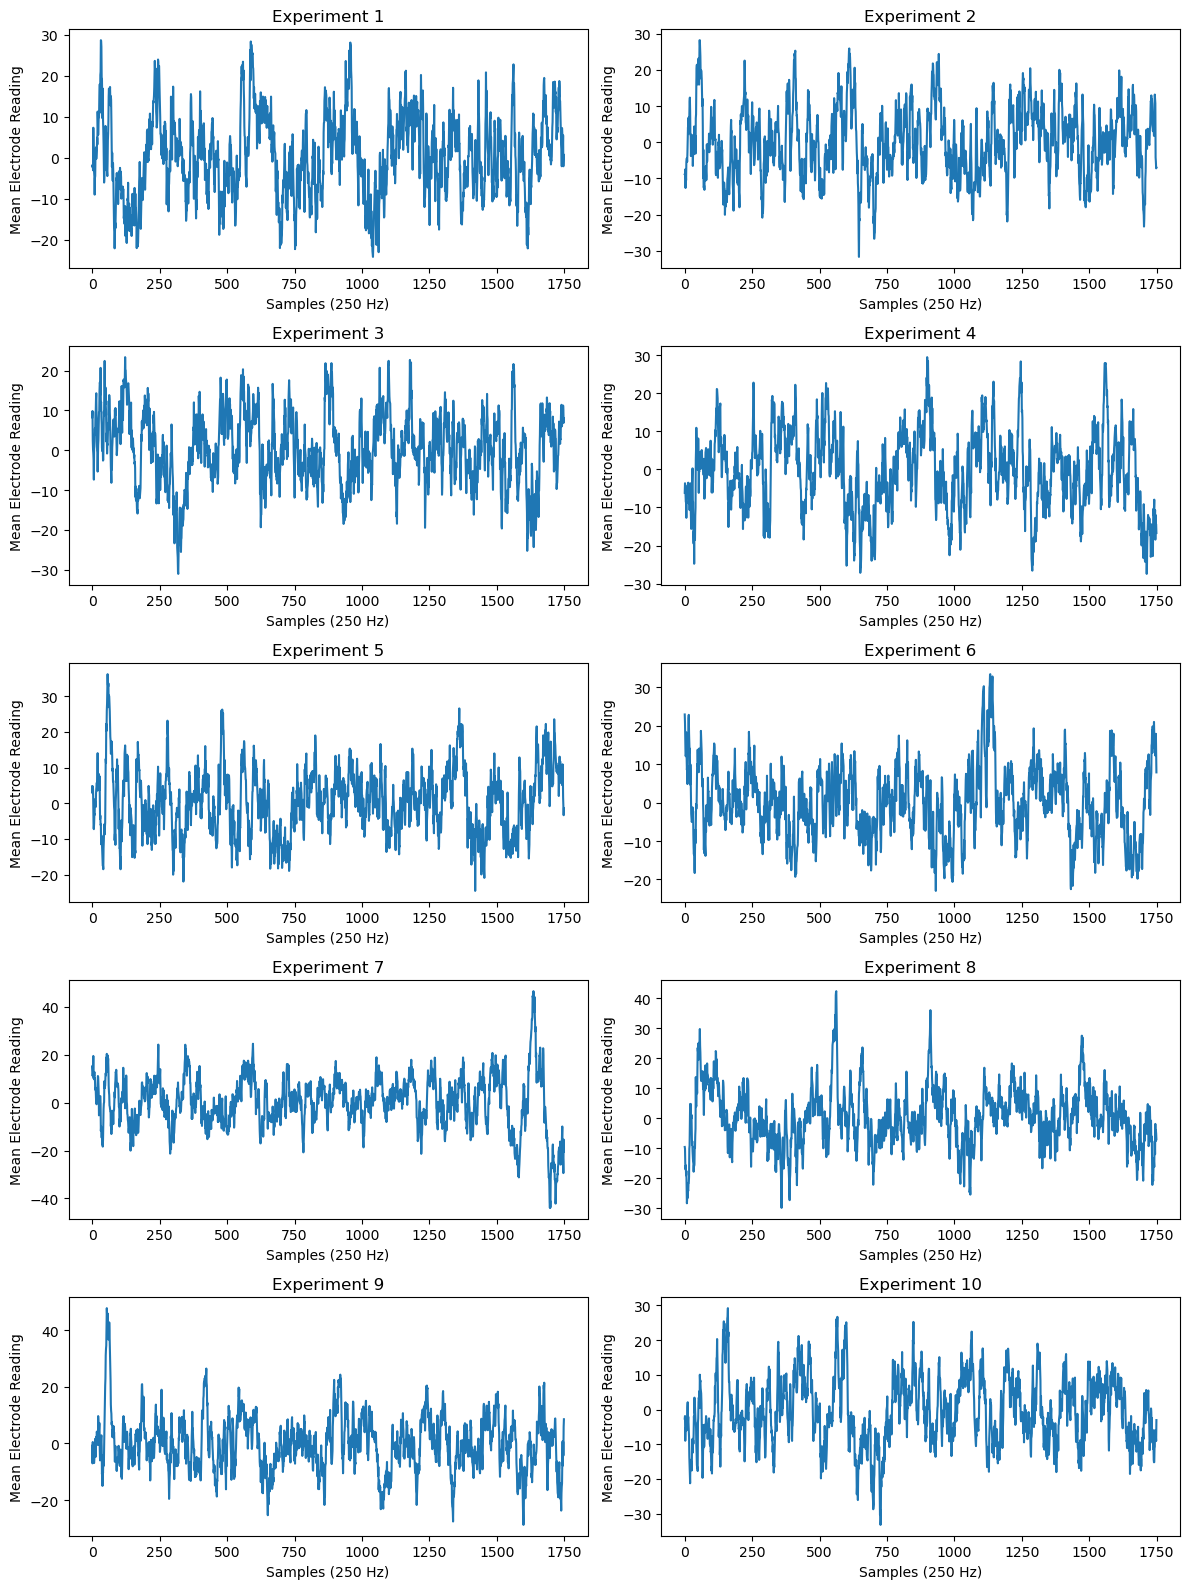

In [19]:
import matplotlib.pyplot as plt

# Create a figure and subplots
fig, axs = plt.subplots(5, 2, figsize=(12, 16))

# Flatten the subplot array to simplify indexing
axs = axs.flatten()

# Plot the first 10 experiments in X
for i in range(10):
    axs[i].plot(X[i])
    axs[i].set_xlabel('Samples (250 Hz)')
    axs[i].set_ylabel('Mean Electrode Reading')
    axs[i].set_title(f'Experiment {i+1}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# **Create Scalograms**

In [13]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

In [14]:
eeg_data = X[0]
y[0]

4.0

In [20]:
for trial,eeg_data in enumerate(X):

    wavelet = 'morl'

    scales = np.arange(1, 512)
    coefficients, frequencies = pywt.cwt(eeg_data, scales, wavelet)

    title = './scalograms/{:02d}_trial_'.format(int(subject))
    title = title+'{:02d}'.format(int(trial))
    # title = title+'__{:1d}.png'.format(int(y_[trial]))

    if (int(y[trial]) == 1):
      title += '__class01.png'
    elif (int(y[trial]) == 2):
      title += '__class02.png'
    elif (int(y[trial]) == 3):
      title += '__class03.png'
    elif (int(y[trial]) == 4):
      title += '__class04.png'
    else:
      print("ERROR: UNKNOWN CLASS IN TRIAL: " . trial)
      continue


    plt.imsave(title, np.abs(coefficients), cmap='jet')


    break

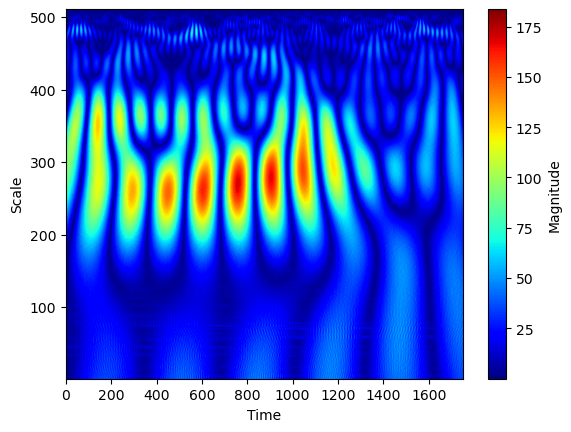

In [22]:
plt.figure()
plt.imshow(np.abs(coefficients), aspect='auto', extent=[0, len(eeg_data), min(scales), max(scales)], cmap='jet')
plt.colorbar(label='Magnitude')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.savefig(title, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import os
import numpy as np
from PIL import Image
# from google.colab import drive
import matplotlib.pyplot as plt


In [ ]:
def load_images_and_labels(folder_path):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):

            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image = image.convert("RGB")

            image = image.resize((224,224))
            image_array = np.array(image) / 255.0
            images.append(image_array)

            if ("class01" in filename) :
                labels.append(0)
            elif "class02" in filename:
                labels.append(1)
            elif "class03" in filename:
                labels.append(2)
            elif "class04" in filename:
                labels.append(3)
            else:
                raise ValueError("Invalid filename format")

    return np.array(images), np.array(labels)

In [ ]:
folder_path = '/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/MotorImagery_IV/Dataset/ScalogramsTesting/'
X, Y = load_images_and_labels(folder_path)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (11, 224, 224, 3)
Shape of Y: (11,)


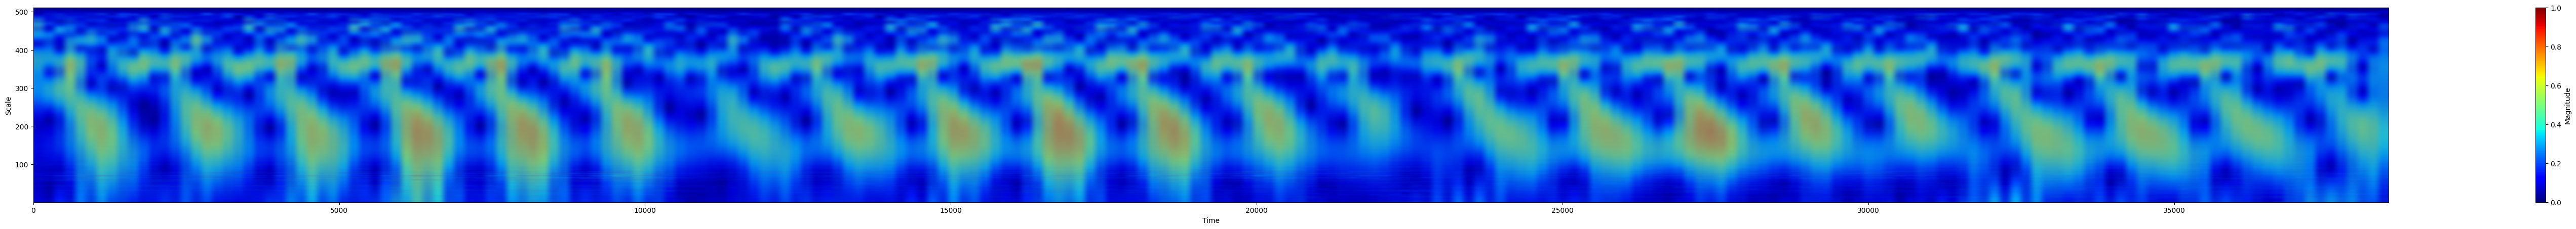

In [ ]:
plt.figure(figsize=(75, 5))
plt.imshow(X[0], aspect='auto', extent=[0, len(eeg_data), min(scales), max(scales)], cmap='jet')
plt.colorbar(label='Magnitude')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.show()

************ <class 'PIL.Image.Image'>
************ (38500, 511)


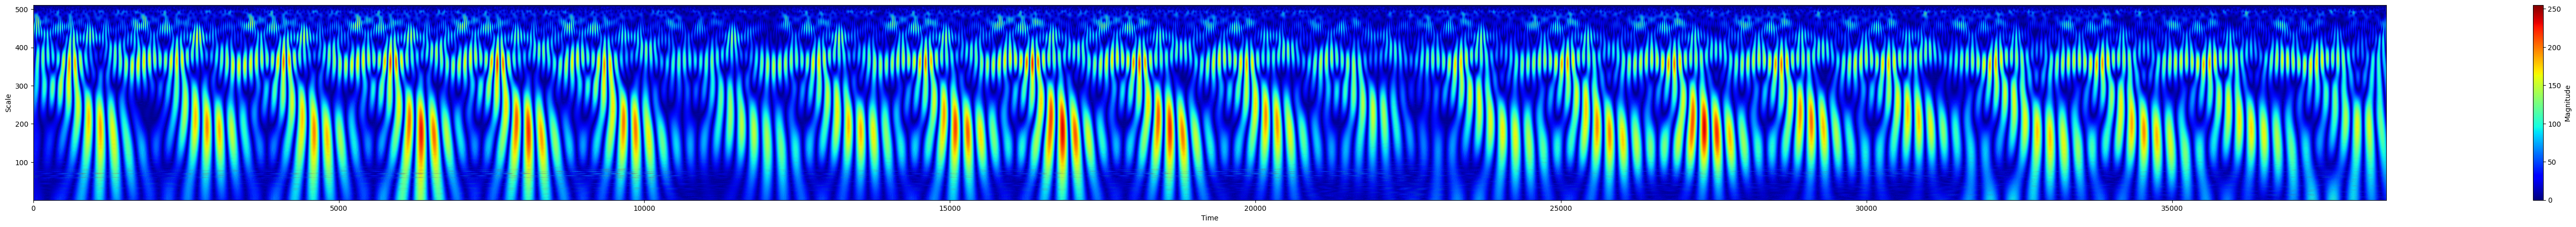

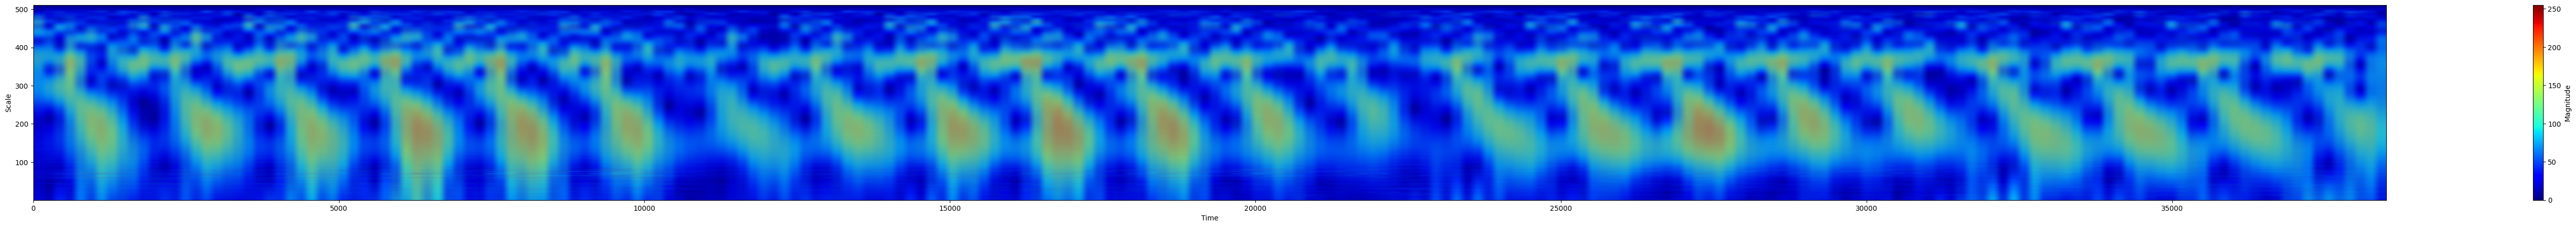

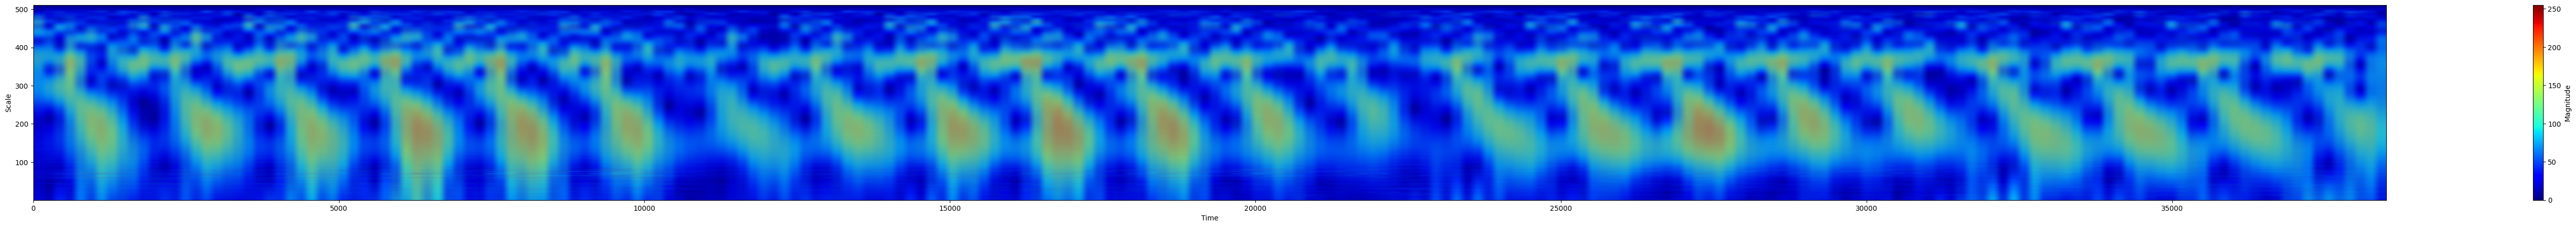

In [ ]:
folder_path = '/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/MotorImagery_IV/Dataset/ScalogramsTesting/'


images = []
labels = []

for filename in os.listdir(folder_path):
    if filename.endswith(".png"):

        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        image = image.convert("RGB")

        print("************", type(image))
        print("************", image.size)

        plt.figure(figsize=(75, 5))
        plt.imshow(image, aspect='auto', extent=[0, len(eeg_data), min(scales), max(scales)], cmap='jet')
        plt.colorbar(label='Magnitude')
        plt.xlabel('Time')
        plt.ylabel('Scale')
        plt.show()

        image = image.resize((224,224))

        plt.figure(figsize=(75, 5))
        plt.imshow(image, aspect='auto', extent=[0, len(eeg_data), min(scales), max(scales)], cmap='jet')
        plt.colorbar(label='Magnitude')
        plt.xlabel('Time')
        plt.ylabel('Scale')
        plt.show()


        image_array = np.array(image) / 255.0

        plt.figure(figsize=(75, 5))
        plt.imshow(image, aspect='auto', extent=[0, len(eeg_data), min(scales), max(scales)], cmap='jet')
        plt.colorbar(label='Magnitude')
        plt.xlabel('Time')
        plt.ylabel('Scale')
        plt.show()


        images.append(image_array)

        if ("class01" in filename) :
            labels.append(0)
        elif "class02" in filename:
            labels.append(1)
        elif "class03" in filename:
            labels.append(2)
        elif "class04" in filename:
            labels.append(3)
        else:
            raise ValueError("Invalid filename format")

        break
